In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.v2.functional as F_v2
from Utils.cfg import modelnet10_cfg
from Utils.utils import get_model, get_writer, get_datasets
from Utils.functional import quaternion_delta, feature_std, feature_entropy, feature_correlation
from Utils.evals import linear_probing, eval_representations

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os

In [2]:
cfg = modelnet10_cfg(
    experiment='action_ablation_littleangles',
    trial='actions',
    model_type='GPA',
    device='cuda',
    consider_actions=True,
)[0]
# cfg = modelnet10_cfg(
#     experiment='trans_layers',
#     trial='GPA_4layers',
#     model_type='GPA',
#     device='cuda',
# )[0]
model = get_model(cfg)
model.eval()
num_params = sum(p.numel() for p in model.parameters())
# model.load_state_dict(torch.load('out/mnist/models/BYOPL/BYOPL_3e-4/0.pth'))
# model.load_state_dict(torch.load('out/mnist/models/iJEPA_cnn/base/0.pth'))
model.load_state_dict(torch.load(f'out/{cfg["dataset"]}/models/{cfg["experiment"]}/{cfg["trial"]}/0.pth'))
print(num_params/1e6)
device = torch.device(cfg['device'])
eval_representations(model, cfg)

C:\Users\joeag\AppData\Local\Temp\ipykernel_33164\226941160.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'out/{cfg["dataset"]}/mode

40.319681


c:\Users\joeag\Documents\AAPA\Examples\ModelNet10\dataset.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.sorted_rot_indices = torch.load(self.root + 'ModelNet10/

{'corr': -0.0009362183045595884,
 'std': 0.011311763897538185,
 'entropy': 0.9957855939865112}

In [5]:
cfg = modelnet10_cfg(
    experiment='action_ablation_littleangles',
    trial='no_actions',
    model_type='GPA',
    device='cuda',
    consider_actions=False,
)[0]
# cfg = modelnet10_cfg(
#     experiment='comparison',
#     trial='iGPA',
#     # trial='iGPA_1000ep',
#     model_type='iGPA',
#     device='cuda',
# )[0]
model2 = get_model(cfg)
model2.eval()
num_params = sum(p.numel() for p in model2.parameters())
# model2.load_state_dict(torch.load('out/mnist/models/BYOPL/BYOPL_3e-4/0.pth'))
# model2.load_state_dict(torch.load('out/mnist/models/iJEPA_cnn/base/0.pth'))
model2.load_state_dict(torch.load(f'out/{cfg["dataset"]}/models/{cfg["experiment"]}/{cfg["trial"]}/0.pth'))
print(num_params/1e6)
device = torch.device(cfg['device'])
eval_representations(model2, cfg)

C:\Users\joeag\AppData\Local\Temp\ipykernel_13772\1898199902.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load(f'out/{cfg["dataset"]}/mo

40.319681


{'corr': -0.0009148426470346749,
 'std': 0.03572964668273926,
 'entropy': 0.9934471845626831}

In [5]:
from torchvision import datasets, transforms
from Examples.ModelNet10.dataset import ModelNet10Simple, ModelNet10
from Utils.dataset import PreloadedDataset

train_set, val_set = get_datasets(cfg)
if cfg['dataset'] == 'mnist':
    t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)
elif cfg['dataset'] == 'modelnet10':
    test_set = ModelNet10(cfg['root'], split='test', device=cfg['device'], use_tqdm=cfg['local'], rank=cfg['ddp_rank'], world_size=cfg['ddp_world_size'], seed=cfg['seed'])
# test_set = PreloadedDataset.from_dataset(t_dataset, transforms.ToTensor(), device, use_tqdm=cfg['local'])

In [3]:
dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)
losses = []
for i, data in enumerate(dataloader):
    with torch.no_grad():
        (img1, rot1, _), (img2, rot2, _) = data
        actions = quaternion_delta(rot1, rot2)
        loss = model.loss(img1, img2, actions, None)
        losses.append(loss.item())
print(np.mean(losses))

NameError: name 'test_set' is not defined

NameError: name 'model2' is not defined

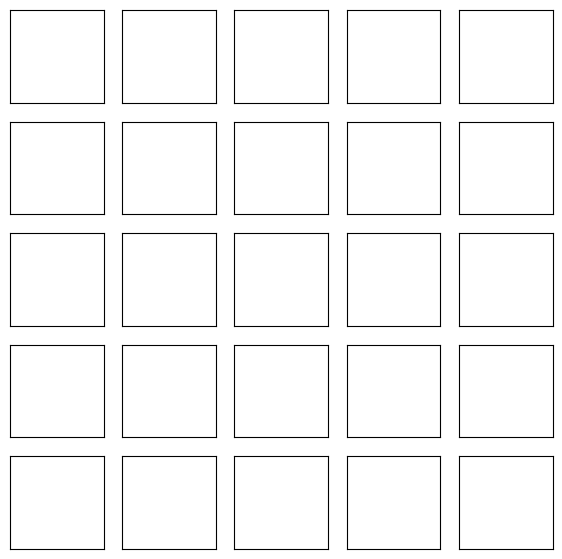

In [6]:
import torch.nn.functional as F
labels_to_name = {
    0: 'bathtub',
    1: 'bed',
    2: 'chair',
    3: 'desk',
    4: 'dresser',
    5: 'monitor',
    6: 'night_stand',
    7: 'sofa',
    8: 'table',
    9: 'toilet'
}

def get_images(dataset):
    images1 = torch.empty((10, 1, 128, 128), dtype=torch.float32, device=cfg['device'])
    images2 = torch.empty((10, 1, 128, 128), dtype=torch.float32, device=cfg['device'])
    rots1 = torch.empty((10, 3), dtype=torch.float32, device=cfg['device'])
    rots2 = torch.empty((10, 3), dtype=torch.float32, device=cfg['device'])

    mean_aug = torch.empty((10, 1, 128, 128), dtype=torch.float32, device=cfg['device'])
    labels = []
    for c in range(10):
        indices = torch.where(dataset.labels == c)[0]
        idx = indices[torch.randint(0, len(indices), (1,))].item()
        rot1 = torch.randint(0, 64, (1,)).item()

        # rot2 = torch.randint(0, 64, (1,)).item()
        rot2 = torch.randint(0, 8, (1,)).item()
        rot2 = dataset.sorted_rot_indices[rot1][rot2]

        images1[c] = dataset.data[idx][rot1] / 255.0
        rots1[c] = dataset.rotations[idx][rot1]
        images2[c] = dataset.data[idx][rot2] / 255.0
        rots2[c] = dataset.rotations[idx][rot2]
        labels.append(labels_to_name[c])
        mean_aug[c] = (dataset.data[idx] / 255.0).mean(dim=0)

    return images1, rots1, images2, rots2, labels, mean_aug

def get_same_images(dataset):
    images1 = torch.empty((10, 1, 128, 128), dtype=torch.float32, device=cfg['device'])
    images2 = torch.empty((10, 1, 128, 128), dtype=torch.float32, device=cfg['device'])
    rots1 = torch.empty((10, 3), dtype=torch.float32, device=cfg['device'])
    rots2 = torch.empty((10, 3), dtype=torch.float32, device=cfg['device'])

    mean_aug = torch.empty((10, 1, 128, 128), dtype=torch.float32, device=cfg['device'])
    labels = []
    
    c = torch.randint(0, 10, (1,)).item()
    indices = torch.where(dataset.labels == c)[0]
    idx = indices[torch.randint(0, len(indices), (1,))].item()
    rot1 = torch.randint(0, 64, (1,)).item()

    for c in range(10):

        # rot2 = torch.randint(0, 64, (1,)).item()
        rot2 = torch.randint(0, 8, (1,)).item()
        rot2 = dataset.sorted_rot_indices[rot1][rot2]

        images1[c] = dataset.data[idx][rot1] / 255.0
        rots1[c] = dataset.rotations[idx][rot1]
        images2[c] = dataset.data[idx][rot2] / 255.0
        rots2[c] = dataset.rotations[idx][rot2]
        labels.append(labels_to_name[c])
        mean_aug[c] = (dataset.data[idx] / 255.0).mean(dim=0)

    return images1, rots1, images2, rots2, labels, mean_aug

def get_set(dataset, model):
    images1, rots1, images2, rots2, labels, mean_aug = get_images(dataset)
    actions = quaternion_delta(rots1, rots2)
    preds = model.predict(images1, actions)
    return images1, images2, preds, labels, mean_aug

def get_set2(dataset, model, model2):
    images1, rots1, images2, rots2, labels, mean_aug = get_same_images(dataset)
    actions = quaternion_delta(rots1, rots2)
    preds = model.predict(images1, actions)
    preds2 = model2.predict(images1, actions)
    # preds2 = preds
    return images1, images2, preds, preds2, labels, mean_aug

def show(model, dataset, groups=1):
    fig, axs = plt.subplots(5*groups, 5, figsize=(7, 7*groups))
    # fig, axs = plt.subplots(3*groups, 5, figsize=(7, 4*groups))
    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    for g in range(groups):
        images, images_aug, preds, preds2, labels, mean_aug = get_set2(dataset, model, model2)
        # for i in range(10):
        for i in range(5):
            if i == 0:
                axs[3*g + 0, i].set_ylabel('Initial', fontsize=12)
                axs[3*g + 1, i].set_ylabel('Target', fontsize=12)
                # axs[3*g + 2, i].set_ylabel('Predicted', fontsize=12)
                axs[3*g + 2, i].set_ylabel('w/ Actions', fontsize=12)
                axs[3*g + 3, i].set_ylabel('w/o Actions', fontsize=12)
                axs[3*g + 4, i].set_ylabel('Mean', fontsize=12)
            # axs[3*g + 0, i].set_title(f'{labels[i]}', fontsize=12)
            axs[3*g + 0, i].imshow(images[i].squeeze().cpu(), cmap='gray')
            axs[3*g + 1, i].imshow(images_aug[i].squeeze().cpu(), cmap='gray')
            axs[3*g + 2, i].imshow(preds[i].squeeze().cpu().detach(), cmap='gray')
            axs[3*g + 3, i].imshow(preds2[i].squeeze().cpu().detach(), cmap='gray')
            axs[3*g + 4, i].imshow(mean_aug[i].squeeze().cpu(), cmap='gray')
    plt.axis('off')
    plt.show()

show(model, test_set, groups=1)

In [17]:
x = torch.randn(10)
x1 = x / x.norm()
x2 = F.normalize(x, dim=0)
x1, x2


(tensor([-0.3297,  0.2182,  0.3451,  0.3071, -0.0047, -0.2497,  0.5039, -0.3750,
          0.1364, -0.3934]),
 tensor([-0.3297,  0.2182,  0.3451,  0.3071, -0.0047, -0.2497,  0.5039, -0.3750,
          0.1364, -0.3934]))

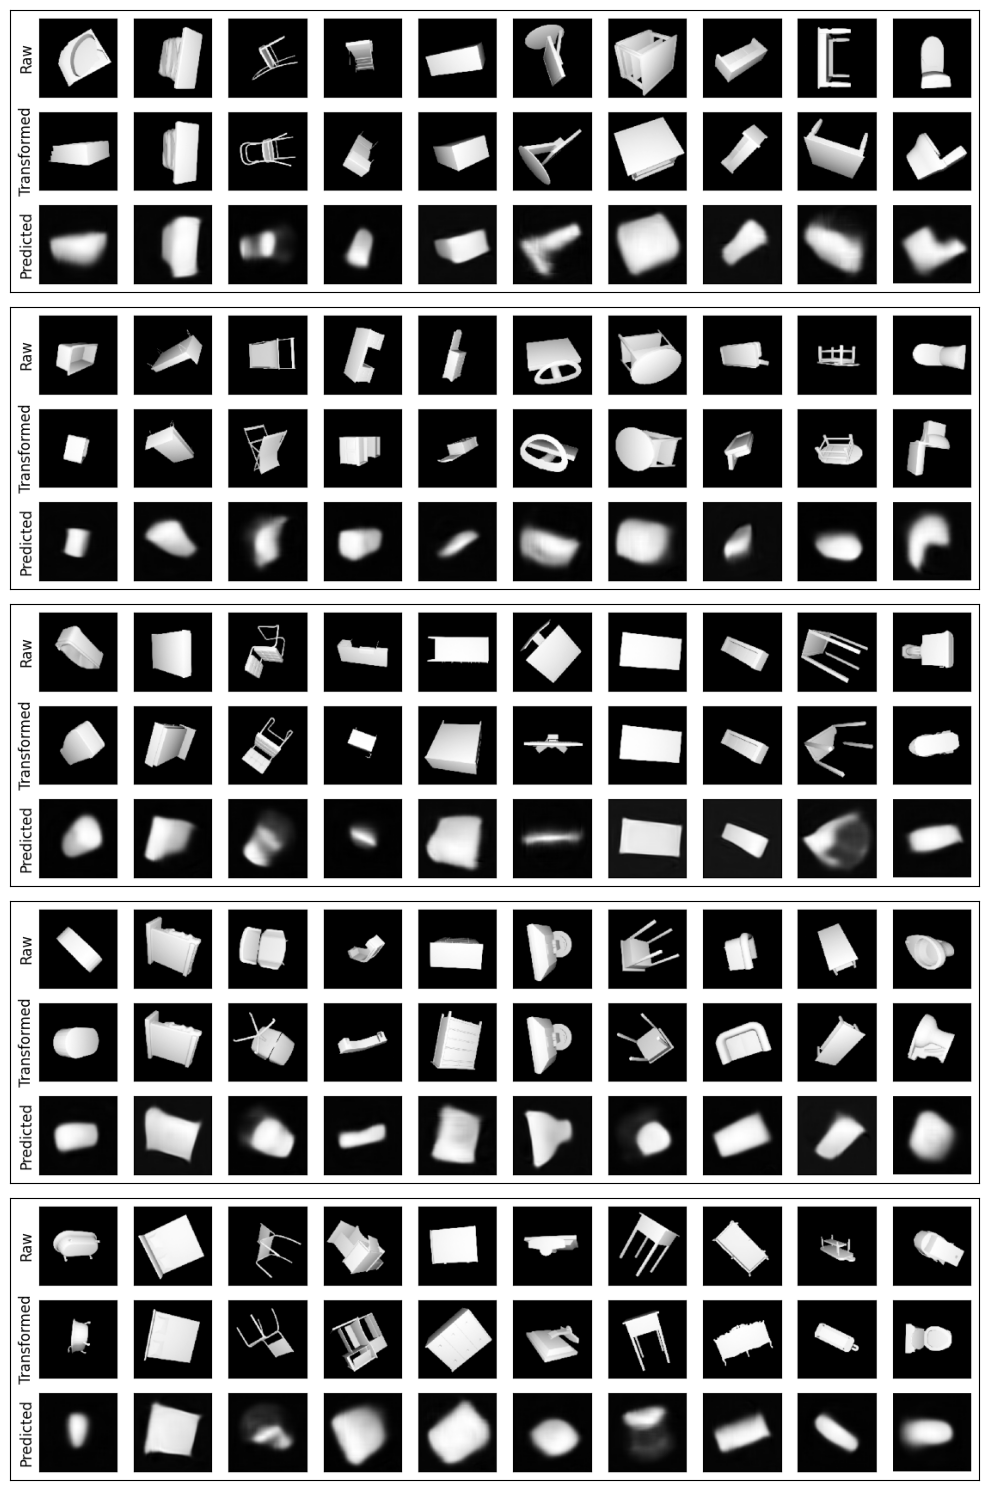

In [20]:
root = 'assets/modelnet10_examples/'
imgs = []
for p in os.listdir(root):
    path = os.path.join(root, p)
    imgs.append(plt.imread(path))

fig, axs = plt.subplots(5, 1, figsize=(10, 15))
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
for i in range(5):
    axs[i].imshow(imgs[i], cmap='gray')
plt.tight_layout()
plt.show()


In [7]:
from Utils.functional import quaternion_delta
def show(model, dataset, obj_idx, rot1_idx, rot2_idx):
    img1 = dataset.data[obj_idx][rot1_idx].to(device) / 255.0
    rot1 = dataset.rotations[obj_idx][rot1_idx]
    rot2_idx = dataset.sorted_rot_indices[rot1_idx][rot2_idx]
    img2 = dataset.data[obj_idx][rot2_idx].to(device) / 255.0
    rot2 = dataset.rotations[obj_idx][rot2_idx]
    actions = quaternion_delta(rot1, rot2)

    pred = model.predict(img1.unsqueeze(0), actions.unsqueeze(0))

    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].imshow(img1.squeeze().cpu(), cmap='gray')
    axs[1].imshow(img2.squeeze().cpu(), cmap='gray')
    axs[2].imshow(pred.squeeze().cpu().detach(), cmap='gray')
    plt.tight_layout()
    plt.show()

interact(show, model=fixed(model), dataset=fixed(train_set), obj_idx=widgets.IntSlider(min=0, max=len(train_set)-1, step=1), rot1_idx=widgets.IntSlider(min=0, max=len(train_set.data[0])-1), rot2_idx=widgets.IntSlider(min=0, max=len(train_set.data[0])-1))






interactive(children=(IntSlider(value=0, description='obj_idx', max=3191), IntSlider(value=0, description='rot…

<function __main__.show(model, dataset, obj_idx, rot1_idx, rot2_idx)>

In [9]:
from Utils.functional import quaternion_delta
def show(model, dataset, obj_idx, rot1_idx, q1, q2, q3, q4):
    img1 = dataset.data[obj_idx][rot1_idx].to(device) / 255.0
    action = torch.tensor([q1, q2, q3, q4]).to(device)
    pred = model.predict(img1.unsqueeze(0), action.unsqueeze(0))

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs[0].imshow(img1.squeeze().cpu(), cmap='gray')
    axs[1].imshow(pred.squeeze().cpu().detach(), cmap='gray')
    plt.tight_layout()
    plt.show()

interact(show, model=fixed(model), dataset=fixed(train_set), obj_idx=widgets.IntSlider(min=0, max=len(train_set)-1, step=1), rot1_idx=widgets.IntSlider(min=0, max=len(train_set.data[0])-1), q1=widgets.FloatSlider(min=-1, max=1, step=0.1), q2=widgets.FloatSlider(min=-1, max=1, step=0.1), q3=widgets.FloatSlider(min=-1, max=1, step=0.1), q4=widgets.FloatSlider(min=-1, max=1, step=0.1))


interactive(children=(IntSlider(value=0, description='obj_idx', max=3191), IntSlider(value=0, description='rot…

<function __main__.show(model, dataset, obj_idx, rot1_idx, q1, q2, q3, q4)>

In [ ]:
from Utils.functional import quaternion_delta
def show(model, dataset, obj_idx, rot1_idx, x, y, z):
    img1 = dataset.data[obj_idx][rot1_idx].to(device) / 255.0
    quat = quaternion_delta(x, y, z)
    action = torch.tensor([q1, q2, q3, q4]).to(device)
    pred = model.predict(img1.unsqueeze(0), action.unsqueeze(0))

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs[0].imshow(img1.squeeze().cpu(), cmap='gray')
    axs[1].imshow(pred.squeeze().cpu().detach(), cmap='gray')
    plt.tight_layout()
    plt.show()

interact(show, model=fixed(model), dataset=fixed(train_set), obj_idx=widgets.IntSlider(min=0, max=len(train_set)-1, step=1), rot1_idx=widgets.IntSlider(min=0, max=len(train_set.data[0])-1), q1=widgets.FloatSlider(min=-1, max=1, step=0.1), q2=widgets.FloatSlider(min=-1, max=1, step=0.1), q3=widgets.FloatSlider(min=-1, max=1, step=0.1), q4=widgets.FloatSlider(min=-1, max=1, step=0.1))

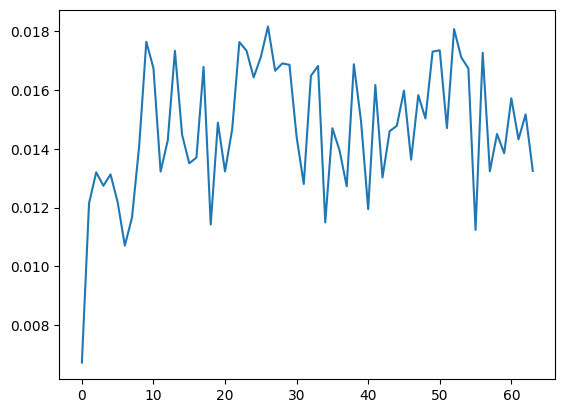

In [8]:
with torch.no_grad():
    idx1 = 37
    losses = []
    batch_size = 128
    img1 = train_set.data[:batch_size,idx1] / 255.0
    rot1 = train_set.rotations[:batch_size,idx1]

    for i in range(64):
        idx2 = train_set.sorted_rot_indices[idx1][i]
        img2 = train_set.data[:batch_size, idx2] / 255.0
        rot2 = train_set.rotations[:batch_size, idx2]
        actions = quaternion_delta(rot1, rot2)
        loss = model.loss(img1, img2, actions, None)
        losses.append(loss.item())

    plt.plot(losses)
    plt.show()





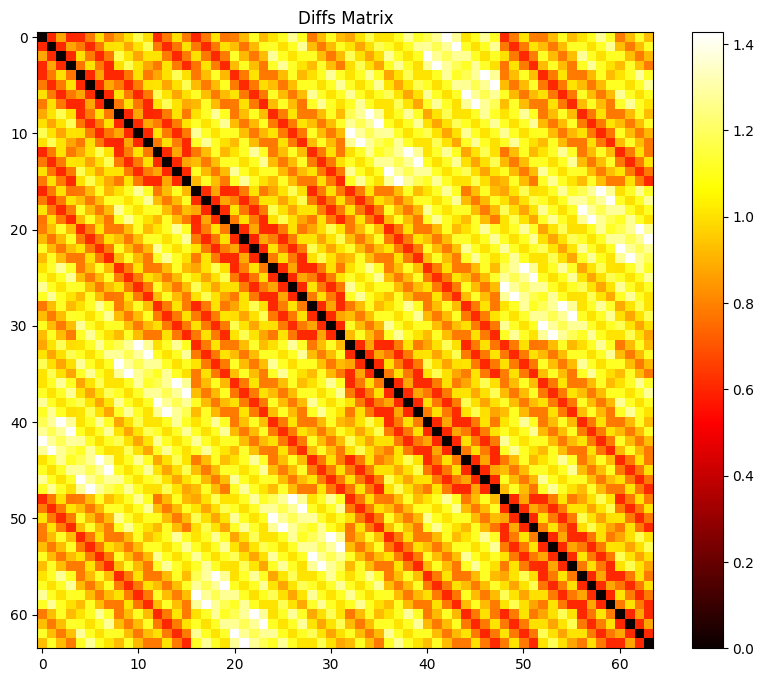

tensor([ 0, 16,  3,  1, 12, 48,  4, 19, 15, 17, 13, 28,  5,  7, 52, 49, 60, 51,
        20,  2, 32,  8, 21, 29, 31, 23, 53, 55, 61, 63,  6, 14, 11,  9, 18, 36,
        50, 33, 56, 35, 24, 44, 30, 27, 57, 54, 25, 45, 47, 39, 59, 22, 37, 62,
        34, 40, 10, 26, 41, 58, 46, 38, 43, 42], device='cuda:0')

In [ ]:
# train_set.rotations[0][:4].shape
diffs = []
for idx in range(len(train_set)):
    rots = train_set.rotations[idx]
    a = rots.expand(rots.shape[0], rots.shape[0], rots.shape[1])
    b = rots.unsqueeze(1).repeat(1, rots.shape[0], 1)
    diffs_a, diffs_b = (a - b).abs(), 360 - (a - b).abs()
    abdiffs = torch.min(diffs_a, diffs_b)
    diffs.append(abdiffs)

diffs = torch.stack(diffs)
diffs = diffs / diffs.max()
diffs = diffs.norm(dim=3).mean(dim=0)

sorted_indices = torch.argsort(diffs, dim=1)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(diffs.cpu().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Diffs Matrix')
plt.show()
diffs[0]

sorted_indices[0]

In [ ]:
dataloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
data = next(iter(dataloader))
(images, _, _), _ = data
embeddings = model(images)
feature_correlation(embeddings)

# # feature_entropy(model(images))
# num_features = 512
# num_samples = 10240
# # x = torch.ones(num_samples, num_features) + torch.randn(num_samples, num_features)*0.0001
# x = torch.randn(num_samples, num_features)*0.0001
# subset_idx = 10
# max_entropy = np.log(num_features)
# print(f'max entropy: {max_entropy}')
# x[:,:subset_idx] = x[:,:subset_idx] + torch.randn(num_samples, subset_idx)*1
# feature_entropy(x), feature_std(x)


tensor(-0.0018, device='cuda:0', grad_fn=<MeanBackward0>)

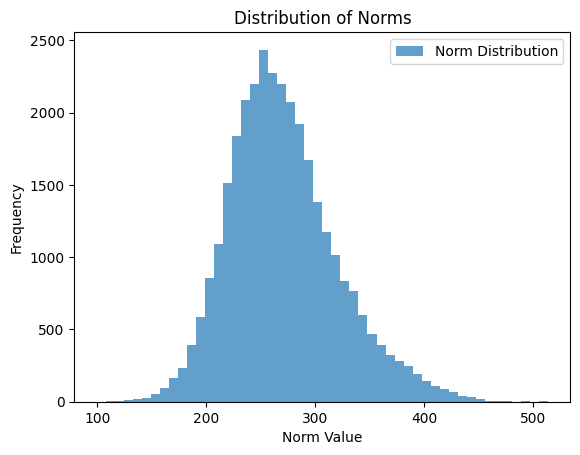

In [ ]:
import numpy as np
from tqdm import tqdm
# (img1, rot1, lab1), (img2, rot2, lab2) = train_set[0]

dataloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

def test():
    norms = []
    for e in range(10):
        loop = tqdm(dataloader, leave=False)
        loop.set_description(f'{e}/10')
        for (_, rot1, _), (_, rot2, _) in dataloader:
            diffs_a = rot2 - rot1
            diffs_b = 360 - diffs_a
            diffs = torch.min(diffs_a, diffs_b)
            norms = norms + diffs.norm(dim=1).tolist()
    return norms

import matplotlib.pyplot as plt

norms = test()
plt.hist(norms, bins=50, alpha=0.7, label='Norm Distribution')
plt.title('Distribution of Norms')
plt.xlabel('Norm Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


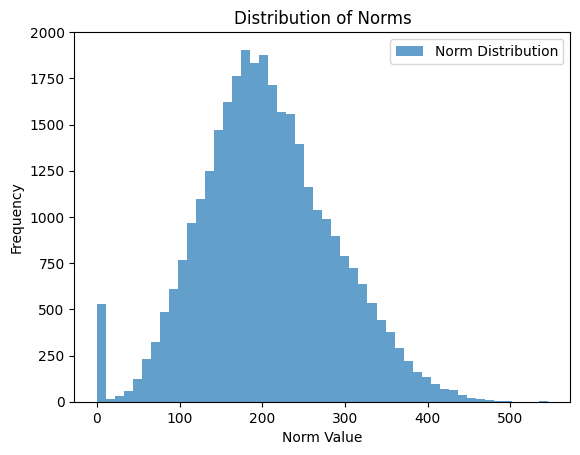

In [ ]:
import numpy as np
from tqdm import tqdm
# (img1, rot1, lab1), (img2, rot2, lab2) = train_set[0]

dataloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

def test():
    norms = []
    for e in range(10):
        loop = tqdm(dataloader, leave=False)
        loop.set_description(f'{e}/10')
        for (_, rot1, _), (_, rot2, _) in dataloader:
            diffs_a = rot2 - rot1
            diffs_b = 360 - diffs_a
            diffs = torch.min(diffs_a, diffs_b)
            norms = norms + diffs.norm(dim=1).tolist()
    return norms

import matplotlib.pyplot as plt

norms = test()
plt.hist(norms, bins=50, alpha=0.7, label='Norm Distribution')
plt.title('Distribution of Norms')
plt.xlabel('Norm Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [1]:
def play(model, dataset, idx, rot1, rot2_idx):
    rot2 = dataset.sorted_rot_indices[rot1][rot2_idx]

    img1 = dataset.data[idx][rot1]
    img2 = dataset.data[idx][rot2]

    rot1 = dataset.rotations[idx][rot1]
    rot2 = dataset.rotations[idx][rot2]
    actions = quaternion_delta(rot1, rot2)

    pred = model.predict(img1, actions)

    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].imshow(img1.squeeze().cpu(), cmap='gray')
    axs[1].imshow(img2.squeeze().cpu(), cmap='gray')
    axs[2].imshow(pred.squeeze().cpu().detach(), cmap='gray')
    plt.tight_layout()
    plt.show()




interact(play, model=fixed(model), dataset=fixed(train_set), idx=widgets.IntSlider(min=0, max=len(train_set)-1, step=1), rot1=widgets.IntSlider(min=0, max=64, step=1), rot2_idx=widgets.IntSlider(min=0, max=64, step=1))


NameError: name 'interact' is not defined